## Grid cell task

We want to start characterizing grid cell activity during our experiment.

The first thing we want to show is a bunch of example of grid cells.

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py

import os.path
import shutil
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu
from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue` is deprecated")

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
setFigureDefaultParameters()

In [4]:
for ses in sSessions:
    ses.load_parameters_from_files() 

In [5]:
fn = myProject.dataPath+"/results/cells.csv"
print("Loading", fn)
cells = pd.read_csv(fn)

fn=myProject.dataPath+"/results/myMaps.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myMaps = pickle.load(fp)
    
fn=myProject.dataPath+"/results/mySpatialAutos.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    mySpatialAutos = pickle.load(fp)

fn=myProject.dataPath+"/results/myControlMaps.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myControlMaps = pickle.load(fp)
    
fn=myProject.dataPath+"/results/myControlSpatialAutos.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myControlSpatialAutos = pickle.load(fp)
        
fn=myProject.dataPath+"/results/myDoughnutCorrelations.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myDoughnutCorrelations = pickle.load(fp)
         
fn=myProject.dataPath+"/results/myMapStats.csv"
print("Loading",fn)
dfMapStats = pd.read_csv(fn)

fn=myProject.dataPath+"/results/myControlMapStats.csv"
print("Loading",fn)
dfControlMapStats = pd.read_csv(fn)


Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/cells.csv
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myMaps.pickle
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/mySpatialAutos.pickle
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myControlMaps.pickle
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myControlSpatialAutos.pickle
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myDoughnutCorrelations.pickle
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myMapStats.csv
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myControlMapStats.csv


In [6]:
fn=myProject.dataPath+"/results/mapCorDf.csv"
print("Loading",fn)
dfMapCor = pd.read_csv(fn)

fn=myProject.dataPath+"/results/mapCorDf_circ80_inter.csv"
print("Loading",fn)
dfMapCor_inter = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/mapCorDf.csv
Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/mapCorDf_circ80_inter.csv


In [7]:
dfMapCor = pd.concat([dfMapCor,dfMapCor_inter])

In [8]:
dfMapCor = dfMapCor.drop_duplicates()

In [9]:
myMaps.keys()

dict_keys(['circ80_lever1', 'circ80_lever2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_arena', 'dark', 'dark_arena', 'light_1', 'light_2', 'dark_1', 'dark_2', 'all_light', 'all_light_1', 'all_light_2', 'all_dark', 'all_dark_1', 'all_dark_2'])

In [10]:
if cells.shape[0] != myMaps["circ80_1"].shape[0]:
    raise ValueError("problem with data format")
if cells.shape[0] != dfMapStats[dfMapStats.condition=="circ80_1"].shape[0]:
    raise ValueError("problem with data format")

In [11]:
cells.shape

(10850, 15)

# Part 1: Maps  of RF1, AutoPI-light, AutoPI-dark, RF2-without lever or RF2-with Lever

In [12]:
selection="gridCell_FIRST" 

In [13]:
# need grid cells from session with circ80_lever1
RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]
print("Number of random foraging with lever sessions:",len(RF2leverSessions))
gc_RF2lever = cells[(cells.usable==True)&(cells[selection]==True)&(cells.session.isin(RF2leverSessions))]
print("Number of grid cells with RF2-lever",len(gc_RF2lever.session))

Number of random foraging with lever sessions: 8
Number of grid cells with RF2-lever 66


In [14]:
circ80Sessions = [ses.name for ses in sSessions if 'circ80' in ses.desen ]
print("Number of random foraging without lever sessions:",len(circ80Sessions))
gc_circ80 = cells[(cells.usable==True)&(cells[selection]==True)&(cells.session.isin(circ80Sessions))]
print("Number of grid cells with circ80",len(gc_circ80.session))

Number of random foraging without lever sessions: 180
Number of grid cells with circ80 931


## Doughnut correlations

Get the doughnut correlations of grid cells in the 5 conditions

In [15]:
cells

,cluId,session,mouse,refractory,refractoryClean,usable,meanRate,sumShortAuto,meanRateStable,gridCell_AND,gridCell_OR,gridCell_FIRST,gridCell,leverCell_all_light,leverCell_all_dark
0,mn8578-30112021-0107_20,mn8578-30112021-0107,mn8578,0.243530,False,False,21.217267,133706.0,True,False,False,False,False,False,True
1,mn8578-30112021-0107_22,mn8578-30112021-0107,mn8578,0.441146,False,False,11.061320,104135.0,True,False,False,False,False,True,True
2,mn8578-30112021-0107_45,mn8578-30112021-0107,mn8578,0.196557,False,False,0.963276,7159.0,False,False,False,False,False,False,False
3,mn8578-30112021-0107_48,mn8578-30112021-0107,mn8578,0.065669,True,False,1.584928,5284.0,False,False,False,False,False,False,False
4,mn8578-30112021-0107_57,mn8578-30112021-0107,mn8578,0.381490,False,False,1.775738,2381.0,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,jp499-25052023-0108_523,jp499-25052023-0108,jp499,0.174846,False,False,3.207400,11883.0,False,False,False,False,False,False,False
10846,jp499-25052023-0108_528,jp499-25052023-0108,jp499,0.113294,True,True,9.156873,43042.0,True,False,False,False,False,True,False
10847,jp499-25052023-0108_530,jp499-25052023-0108,jp499,0.040815,True,True,16.113786,150607.0,True,False,False,False,False,False,False
10848,jp499-25052023-0108_533,jp499-25052023-0108,jp499,0.086744,True,True,6.204651,25186.0,True,False,False,False,False,True,False


In [16]:
def plot_grid_cell_doughnut_correlations(spec,myDoughnutCorrelations,cells):
    """
    Function to plot the firing rate maps of grid cells
    
    Arguments:
    spec: A spec with one col and one row on which you want to place the examples maps
    myMap: dictionary with the maps
    
    """
    
    ncols=5
    nrows=1 #
    
    
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1,
                                                width_ratios = [0.3]+[1.0]*ncols, # so that it aligns perfectly with maps
                                                height_ratios = [0.3]+[1.0]*nrows,
                                                subplot_spec=spec[0])
    
    titleSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1, 
                                                 
                                                 width_ratios = [0.6]+[1.0]*ncols,
                                                 height_ratios=[0.1]+[1.4]*nrows,
                                                 subplot_spec=spec[0])

    
    
    RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]
    
    
    # Condition names
    for i,c in enumerate(["RF1", "Light", "Dark", "RF2", "RF3 (lever)"]):
        ax = fig.add_subplot(titleSpec[0,i+1]) # add an axes to the figure
        ax.text(0.5, 1, c,fontsize=9,horizontalalignment='center',verticalalignment='top',)
        ax.axis('off')
    
    
    # Matrices
    conditions=["circ80_1","light","dark","circ80_2" ,"circ80_lever1"]
    for i,c in enumerate(conditions):
        ax = fig.add_subplot(plotSpec[1,i+1]) # add an axes to the figure
        if c == "circ80_lever1":
            m = myDoughnutCorrelations[c][(cells.gridCell_FIRST==True) & (cells.session.isin(RF2leverSessions))]
        else:
            m = myDoughnutCorrelations[c][cells.gridCell_FIRST==True]
        
        if i == 0:
            ax.set_ylabel("Grid cells")
            ax.set_xlabel("Rotation")
            ax.set_xticks(ticks=[0, np.pi/2, np.pi])
            ax.set_xticklabels([r'0', r"$\pi/2$", r'$\pi$'])
        else:
            ax.set_ylabel("")
            ax.set_xlabel("")
            ax.set_xticks(ticks=[])
        
        
        
        
        ax.set_yticks([])
        ax.imshow(m,aspect="auto",interpolation=None,extent=[0, np.pi, 0,m.shape[0]])

## Stats for the analysis of firing rate maps.

We want the grid score in the 5 conditions.

In [17]:
gc = cells[(cells.usable==True)&(cells.gridCell_AND==True)]
print("Number of grid cells",len(gc.session))

# need grid cells from session with circ80_lever1
RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]
print("Number of random foraging with lever sessions:",len(RF2leverSessions))

gc_RF2lever = cells[(cells.usable==True)&(cells.gridCell_AND==True)&(cells.session.isin(RF2leverSessions))]
print("Number of grid cells with RF2-lever",len(gc_RF2lever.session))
print("Number of mice with grid cells during RF2lever:",len(gc_RF2lever.mouse.unique()))

Number of grid cells 642
Number of random foraging with lever sessions: 8
Number of grid cells with RF2-lever 49
Number of mice with grid cells during RF2lever: 4


In [18]:
dfMapStats.condition.unique()

array(['searchToLeverPath_light', 'searchToLeverPath_light_1',
       'searchToLeverPath_light_2', 'searchToLeverPath_dark',
       'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2',
       'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1',
       'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark',
       'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2',
       'circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2',
       'light', 'light_arena', 'dark', 'dark_arena', 'light_1', 'light_2',
       'dark_1', 'dark_2', 'all_light', 'all_light_1', 'all_light_2',
       'all_dark', 'all_dark_1', 'all_dark_2', 'circ80_lever1',
       'circ80_lever2'], dtype=object)

In [19]:
np.array([240, 97, 67])/255

array([0.94117647, 0.38039216, 0.2627451 ])

In [20]:
np.array([78, 136, 148])/255

array([0.30588235, 0.53333333, 0.58039216])

# Figure after review

In [21]:
def plot_grid_cell_examples_two_lever(spec,myMaps):
    """
    Function to plot the firing rate maps of grid cells
    
    Arguments:
    spec: A spec with one col and one row on which you want to place the examples maps
    myMap: dictionary with the maps
    
    """
    
    ncols=6
    nrows=4 # 2 without RF2-lever, 2 with RF2-lever
    mapSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1,
                                               height_ratios = [0.5]+[1.0]*nrows,
                                               width_ratios = [0.5]+[1.0]*ncols,
                                               subplot_spec=spec[0])
    
    titleSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1, 
                                                 height_ratios=[0.3]+[1.0]*nrows,
                                                 width_ratios = [0.5]+[1.0]*ncols,
                                                 subplot_spec=spec[0])

    # Get 4 grid cells from the last session 
    
    n=4
    
    # Second two neurons with the lever in the second random foraging
    RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]
    exampleCells = cells[(cells.usable==True)&(cells.gridCell_AND==True)&(cells.session.isin(RF2leverSessions))].sample(n=n,random_state=4)
    print(exampleCells)
    exampleIndex = exampleCells.index
    
    
    # Condition names
    for i,c in enumerate(["RF1", "AutoPI\nLight", "AutoPI\nDark", "RF2", "RF3 lever\npos. 1","RF3 lever\npos. 2"]):
        ax = fig.add_subplot(titleSpec[0,i+1]) # add an axes to the figure
        ax.text(0.5, 1, c,fontsize=9,horizontalalignment='center',verticalalignment='top',)
        ax.axis('off')
        
    # Cell names
    for i in range(1,5):
        ax = fig.add_subplot(titleSpec[i,0]) # add an axes to the figure
        ax.text(0.5, 0.8, "Cell {}".format(i),fontsize=9,horizontalalignment='center',verticalalignment='top',rotation=90)
        ax.axis('off')

    # Maps
    conditions=["circ80_1","light_arena","dark_arena","circ80_2" ,"circ80_lever1","circ80_lever2"]
    for i,c in enumerate(conditions):
        for j,(ind,cluId) in enumerate(zip(exampleIndex,exampleCells.cluId)):
            ax = fig.add_subplot(mapSpec[j+1,i+1]) # add an axes to the figure
            m = myMaps[c][ind,0:-1,0:-1]
            plotMap(ax,m,title="",titleY=0.95,titleFontSize=8,cmap = 'viridis') 
            title = "{:.1f} Hz".format(np.nanmax(m))
            ax.text(m.shape[0]/2, m.shape[1]+1, title,fontsize=7,horizontalalignment='center',verticalalignment='center',)
            
            # arena
            x = np.cos(np.linspace(0,2*np.pi,100))*40/3 + m.shape[0]/2
            y = np.sin(np.linspace(0,2*np.pi,100))*40/3 + m.shape[1]/2
            ax.plot(x,y, "--",color="grey", alpha=0.5)

                         cluId               session   mouse  refractory  \
2826  jp1686-29042022-0109_189  jp1686-29042022-0109  jp1686    0.081283   
6213  jp3269-30112022-0110_329  jp3269-30112022-0110  jp3269    0.030641   
3228  jp3120-27052022-0110_160  jp3120-27052022-0110  jp3120    0.053101   
2813  jp1686-29042022-0109_119  jp1686-29042022-0109  jp1686    0.026066   

      refractoryClean  usable  meanRate  sumShortAuto  meanRateStable  \
2826             True    True  2.501244       20135.0            True   
6213             True    True  3.243708       50818.0            True   
3228             True    True  3.416877       25006.0            True   
2813             True    True  2.728347       25217.0            True   

      gridCell_AND  gridCell_OR  gridCell_FIRST  gridCell  \
2826          True         True            True      True   
6213          True         True            True      True   
3228          True         True            True      True   
2813     

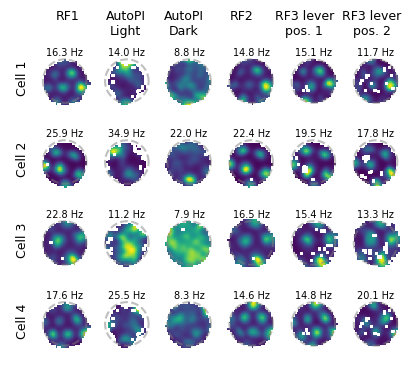

In [22]:
rowSize,colSize= 0.8 ,0.8 #figurePanelDefaultSize()
ncols=5
nrows=4.5
#sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # to be passed to a drawing function, one row and one column, in this case covering the entire figure but does not have to be.

plot_grid_cell_examples_two_lever(mainSpec,myMaps)

In [23]:
def plot_grid_cell_doughnut_correlations_two_lever(spec,myDoughnutCorrelations,cells):
    """
    Function to plot the firing rate maps of grid cells
    
    Arguments:
    spec: A spec with one col and one row on which you want to place the examples maps
    myMap: dictionary with the maps
    
    """
    
    ncols=6
    nrows=1 #
    
    
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1,
                                                width_ratios = [0.3]+[1.0]*ncols, # so that it aligns perfectly with maps
                                                height_ratios = [0.3]+[1.0]*nrows,
                                                subplot_spec=spec[0])
    
    titleSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols+1, nrows=nrows+1, 
                                                 
                                                 width_ratios = [0.6]+[1.0]*ncols,
                                                 height_ratios=[0.1]+[1.4]*nrows,
                                                 subplot_spec=spec[0])

    
    
    RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]
    
    
    # Condition names
    for i,c in enumerate(["RF1", "Light", "Dark", "RF2", "RF3_L1", "RF3_L2"]):
        ax = fig.add_subplot(titleSpec[0,i+1]) # add an axes to the figure
        ax.text(0.5, 1, c,fontsize=9,horizontalalignment='center',verticalalignment='top',)
        ax.axis('off')
    
    
    # Matrices
    conditions=["circ80_1","light","dark","circ80_2" ,"circ80_lever1","circ80_lever2"]
    for i,c in enumerate(conditions):
        ax = fig.add_subplot(plotSpec[1,i+1]) # add an axes to the figure
        if c == "circ80_lever1":
            m = myDoughnutCorrelations[c][(cells.gridCell_FIRST==True) & (cells.session.isin(RF2leverSessions))]
        elif c == 'circ80_lever2':
            m = myDoughnutCorrelations[c][(cells.gridCell_FIRST==True) & (cells.session.isin(RF2leverSessions))]
        else:
            m = myDoughnutCorrelations[c][cells.gridCell_FIRST==True]
        
        if i == 0:
            ax.set_ylabel("Grid cells")
            ax.set_xlabel("Rotation")
            ax.set_xticks(ticks=[0, np.pi/2, np.pi])
            ax.set_xticklabels([r'0', r"$\pi/2$", r'$\pi$'])
        else:
            ax.set_ylabel("")
            ax.set_xlabel("")
            ax.set_xticks(ticks=[])
        
        
        
        
        ax.set_yticks([])
        ax.imshow(m,aspect="auto",interpolation=None,extent=[0, np.pi, 0,m.shape[0]])

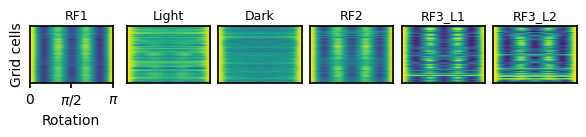

In [24]:
rowSize,colSize= 0.9,1 #figurePanelDefaultSize()
ncols=6
nrows=1.4
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # to be passed to a drawing function, one row and one column, in this case covering the entire figure but does not have to be.

plot_grid_cell_doughnut_correlations_two_lever(mainSpec,myDoughnutCorrelations,cells)

In [25]:
def maps_with_doughnut_rotation_two_lever(spec):
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[4.0,1.5], subplot_spec=spec[0])
    topSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[0,:])
    bottomSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,:])
    
    plot_grid_cell_examples_two_lever(topSpec,myMaps)
    plot_grid_cell_doughnut_correlations_two_lever(bottomSpec,myDoughnutCorrelations,cells)


Figure width: 5.4
Figure height: 5.2
                         cluId               session   mouse  refractory  \
2826  jp1686-29042022-0109_189  jp1686-29042022-0109  jp1686    0.081283   
6213  jp3269-30112022-0110_329  jp3269-30112022-0110  jp3269    0.030641   
3228  jp3120-27052022-0110_160  jp3120-27052022-0110  jp3120    0.053101   
2813  jp1686-29042022-0109_119  jp1686-29042022-0109  jp1686    0.026066   

      refractoryClean  usable  meanRate  sumShortAuto  meanRateStable  \
2826             True    True  2.501244       20135.0            True   
6213             True    True  3.243708       50818.0            True   
3228             True    True  3.416877       25006.0            True   
2813             True    True  2.728347       25217.0            True   

      gridCell_AND  gridCell_OR  gridCell_FIRST  gridCell  \
2826          True         True            True      True   
6213          True         True            True      True   
3228          True         True  

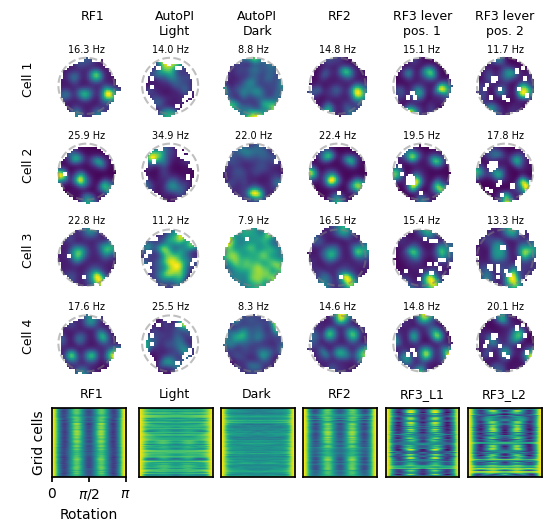

In [26]:
rowSize,colSize= 1.3,0.9
ncols=6
nrows=4.0 
print("Figure width: {}".format(ncols*colSize))
print("Figure height: {}".format(nrows*rowSize))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1) #
maps_with_doughnut_rotation_two_lever(mainSpec)


In [27]:
import scipy

conditionList = ["circ80_1","light_arena","dark_arena","circ80_2","circ80_lever1","circ80_lever2"]
def addLabelToDf(df):
    df["label"]=np.nan
    df.label[df.condition=="circ80_1"] = "RF1"    
    df.label[df.condition=="circ80_2"] = "RF2"
    df.label[df.condition=="light_arena"] = "Light"    
    df.label[df.condition=="dark_arena"] = "Dark"  
    df.label[df.condition=="circ80_lever1"] = "RF3-L1"
    df.label[df.condition=="circ80_lever2"] = "RF3-L2"

def labelOrder():
    return ["RF1","Light", "Dark", "RF2","RF3-L1","RF3-L2"]

def myPalette():
    RF = (0.30588235, 0.53333333, 0.58039216) 
    return {"RF1": RF,
           "RF2": RF,
           "Light": darkLightColors()[1],
           "Dark": darkLightColors()[0],
           "RF3-L1": RF,
           "RF3-L2": RF}

XTICKLABELS = ["RF1","Light", "Dark", "RF2","RF3\nL1","RF3\nL2"]
        
def plotGridScoresLever(ax,dfMapStats, selection="gridCell_AND",statUnit="cell",occupancyControlledStats=False,dfControlMapStats=None,printStats=False): 
    dfGrid = dfMapStats[dfMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
    df = dfGrid[["gridScore","condition","mouse"]]
    df = df[df.condition.isin(conditionList)]
    
    if occupancyControlledStats:        
        dfGridControl = dfControlMapStats[dfControlMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
        df.gridScore[df.condition=="circ80_2"] = dfGridControl.gridScore[dfGridControl.condition=="circ80_2-light"].to_numpy()
    
    if statUnit=="mouse":
        df=df.groupby(["condition","mouse"]).gridScore.median().reset_index()
        
    addLabelToDf(df)
    
    g = sns.boxplot(data=df,x="label",y="gridScore",showfliers=False,order=labelOrder(),palette=myPalette())
    sns.stripplot(data=df, x="label",y="gridScore",order = labelOrder(),alpha=0.7,palette=myPalette(),
                  size=5,edgecolor='#373737', linewidth=1, color='black')
    

    ymax=2
    ax.set_xlabel("")
    
    ax.set_ylim(-0.5,ymax)
    ax.set_ylabel("Grid score")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.set_xticklabels(XTICKLABELS,fontsize=8)

    pairs = [("RF2","Light"),("RF2","Dark")]
    
    annotator = Annotator(g, pairs, data=df,x="label",y="gridScore",order = labelOrder())
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    
    s,p = wilcoxon(df[df.condition=="light_arena"].gridScore,df[df.condition=="circ80_2"].gridScore)
    n = len(df[df.condition=="circ80_2"])    
    n_lever=np.sum(~np.isnan(df[df.condition=="circ80_lever1"].gridScore))
     
   
    if printStats:
        print("**************Grid score stats************")
        s,p = wilcoxon(df[df.condition=="light_arena"].gridScore,df[df.condition=="circ80_2"].gridScore)
        n = len(df[df.condition=="circ80_2"])
        print("Statistics grid scores, Wilcoxon, Light vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    
    if printStats:
        s,p = wilcoxon(df[df.condition=="dark_arena"].gridScore,df[df.condition=="circ80_2"].gridScore)
        n = len(df[df.condition=="circ80_2"])
        print("Statistics grid scores, Wilcoxon, Dark vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
    if printStats:
        # I am using a scipy.stats.mannwhitneyu test because we don't have all animals in the RF3-lever condition
        # Not using a paired-test means that it is less poweful (more conservative).
        leverGridScores = df[df.condition=="circ80_lever1"].gridScore 
        leverGridScores = leverGridScores[~np.isnan(leverGridScores)]
        u,p = mannwhitneyu(df[df.condition=="light_arena"].gridScore,leverGridScores)
        n1 = len(df[df.condition=="light_arena"].gridScore)
        n2 = len(leverGridScores)
        print("Statistics grid scores, Mann-Whitney U test, Light vs RF3-lever")
        print("N1={}, N2={}, U={}, {}".format(n1,n2,u,formatPValue(p)))
        print("")
        
        
    
    
    
def plotMeanRateLever(ax,dfMapStats,selection="gridCell_AND",statUnit="cell",printStats=False): 
    dfGrid = dfMapStats[dfMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
    df = dfGrid[["meanRate","condition","mouse"]]
    df = df[df.condition.isin(conditionList)]
    
    if statUnit=="mouse":
        df=df.groupby(["condition","mouse"]).meanRate.median().reset_index()
    
    addLabelToDf(df)
    g = sns.boxplot(data=df,x="label",y="meanRate",showfliers=False,order=labelOrder(),palette=myPalette())
    sns.stripplot(data=df, x="label",y="meanRate",order = labelOrder(),alpha=0.7,palette=myPalette(),
                  size=5,edgecolor='#373737', linewidth=1, color='black')

    ax.set_xlabel("")
    ymax=10
    ax.set_ylim(0,ymax)
    ax.set_ylabel("Mean rate")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.tick_params(axis='x', rotation=0)
     
    ax.set_xticklabels(XTICKLABELS,fontsize=8)
    
    s,p = wilcoxon(df["meanRate"][df.condition=="light_arena"],df["meanRate"][df.condition=="circ80_2"])
    n = len(df[df.condition=="circ80_2"]) 
    n_lever=np.sum(~np.isnan(df[df.condition=="circ80_lever1"].meanRate))
   
    pairs = [("RF2","Light"),("RF2","Dark")]

    annotator = Annotator(g, pairs, data=df,x="label",y="meanRate",order = labelOrder())
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    
    if printStats:
        print("**************Mean rate stats************")
        print("Statistics mean rate, Wilcoxon, Light vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    
    
    if printStats:
        s,p = wilcoxon(df["meanRate"][df.condition=="dark_arena"],df["meanRate"][df.condition=="circ80_2"])
        print("Statistics mean rate, Wilcoxon, Dark vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    if printStats:
        s,p = wilcoxon(df["meanRate"][df.condition=="dark_arena"],df["meanRate"][df.condition=="light_arena"])
        print("Statistics mean rate, Wilcoxon, Dark vs Light")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        a = df["meanRate"][df.condition=="dark_arena"].to_numpy()
        b = df["meanRate"][df.condition=="light_arena"].to_numpy()
        print("Median of Dark Vs Light difference in mean rate: {:.2f} Hz".format(np.median(a-b)))

        
def plotInfoScoresLever(ax,dfMapStats,selection="gridCell_AND",statUnit="cell",occupancyControlledStats=True,dfControlMapStats=None,printStats=False): 
    dfGrid = dfMapStats[dfMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
    df = dfGrid[["info","condition","mouse"]]
    df = df[df.condition.isin(conditionList)]
    
    if occupancyControlledStats:        
        dfGridControl = dfControlMapStats[dfControlMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
        df["info"][df.condition=="circ80_2"] = dfGridControl["info"][dfGridControl.condition=="circ80_2-light"].to_numpy()
    
    
    if statUnit=="mouse":
        df=df.groupby(["condition","mouse"]).info.median().reset_index()
    
    addLabelToDf(df)
    g = sns.boxplot(data=df,x="label",y="info",showfliers=False,order=labelOrder(),palette=myPalette())
    sns.stripplot(data=df, x="label",y="info",order = labelOrder(),alpha=0.7,palette=myPalette(),
                  size=5,edgecolor='#373737', linewidth=1, color='black')

    ax.set_xlabel("")
    ymax=3
    ax.set_ylim(0,ymax)
    ax.set_ylabel("Info score")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.tick_params(axis='x', rotation=0)
    ax.set_xticklabels(XTICKLABELS,fontsize=8)

    pairs = [("Light","Dark"),("RF2","Dark")]

    annotator = Annotator(g, pairs, data=df,x="label",y="info",order = labelOrder())
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    s,p = wilcoxon(df["info"][df.condition=="light_arena"],df["info"][df.condition=="circ80_2"])
    n = len(df[df.condition=="circ80_2"]) 

    if printStats:
        print("**************Info score stats************")
        print("Statistics info scores, Wilcoxon, Light vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    s,p = wilcoxon(df["info"][df.condition=="dark_arena"],df["info"][df.condition=="circ80_2"])
    if printStats:
        print("Statistics info scores, Wilcoxon, Dark vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    
    s,p = wilcoxon(df["info"][df.condition=="dark_arena"],df["info"][df.condition=="light_arena"])
    if printStats:
        print("Statistics info scores, Wilcoxon, Dark vs Light")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        print("")

    
        
def plotPeakRatesLever(ax,dfMapStats,selection="gridCell_AND",statUnit="cell",occupancyControlledStats=True,dfControlMapStats=None,printStats=False): 
    dfGrid = dfMapStats[dfMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
    df = dfGrid[["peakRate","condition","mouse"]]
    df = df[df.condition.isin(conditionList)]

    if occupancyControlledStats:        
        dfGridControl = dfControlMapStats[dfControlMapStats.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
        df["peakRate"][df.condition=="circ80_2"] = dfGridControl["peakRate"][dfGridControl.condition=="circ80_2-light"].to_numpy()
    
    
    if statUnit=="mouse":
        df=df.groupby(["condition","mouse"]).peakRate.median().reset_index()

    addLabelToDf(df)
    g = sns.boxplot(data=df,x="label",y="peakRate",showfliers=False,order=labelOrder(),palette=myPalette())
    sns.stripplot(data=df, x="label",y="peakRate",order = labelOrder(),alpha=0.7,palette=myPalette(),
                  size=5,edgecolor='#373737', linewidth=1, color='black')
   

    ax.set_xlabel("")
    ymax=25
    ax.set_ylim(0,ymax)
    ax.set_ylabel("Peak rate")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.tick_params(axis='x', rotation=0)
    ax.set_xticklabels(XTICKLABELS,fontsize=8)
    
    pairs = [("Light","Dark"),("RF2","Dark")]

    annotator = Annotator(g, pairs, data=df,x="label",y="peakRate",order = labelOrder())
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    s,p = wilcoxon(df["peakRate"][df.condition=="light_arena"],df["peakRate"][df.condition=="circ80_2"])
    n = len(df[df.condition=="circ80_2"]) 

    if printStats:
        print("**************Peak rate stats************")
        print("Statistics peak rates, Wilcoxon, Light vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    s,p = wilcoxon(df["peakRate"][df.condition=="dark_arena"],df["peakRate"][df.condition=="circ80_2"])
    if printStats:
        print("Statistics peak rates, Wilcoxon, Dark vs RF2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
    
    
    s,p = wilcoxon(df["peakRate"][df.condition=="dark_arena"],df["peakRate"][df.condition=="light_arena"])
    if printStats:
        print("Statistics peak rates, Wilcoxon, Dark vs Light")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        print()
    

    
def addLabelToDfSim(df):
    df["label"]=np.nan
    df.label[df.condition=="o1o2"] = "RF1-RF2"   
    df.label[df.condition=="o1l"] = "RF1-Light"
    df.label[df.condition=="o1d"] = "RF1-Dark"    
    df.label[df.condition=="ld"] = "Light-Dark"    
    df.label[df.condition=="l1l2"] = "Light1-Light2"    
    df.label[df.condition=="d1d2"] = "Dark1-Dark2"
    df.label[df.condition=="o1oL1"] = "RF1-RF3_lever"
    df.label[df.condition=="oL1oL2"] = "RF3_lever-RF3_lever2"



def labelOrderSim():
     return ["RF1-RF2","RF1-RF3_lever","RF3_lever-RF3_lever2","RF1-Light", "RF1-Dark", "Light-Dark", "Light1-Light2", "Dark1-Dark2"] 

def map_stabilityLever(ax,dfMapCor,cells,statUnit="mouse",selection="gridCell_FIRST",printStats=True):

    dfGrid = dfMapCor[dfMapCor.cellId.isin(cells[cells[selection]==True].cluId)] # keep only grid cells
    if statUnit=="mouse":
        dfGrid=dfGrid.groupby(["condition","mouse"]).r.median().reset_index()   
    addLabelToDfSim(dfGrid)
    
    myCol=(0.30588235, 0.53333333, 0.58039216)
    sns.boxplot(data=dfGrid,y="label",x="r",showfliers=False,order=labelOrderSim(),color=myCol)
    sns.stripplot(data=dfGrid, y="label",x="r",order = labelOrderSim(),alpha=0.7,color=myCol,
                   size=5,edgecolor='#373737', linewidth=1)
    ymax=1.0
    ax.set_xlim(-0.25,ymax)
    ax.set_xlabel("Map similarity (r)")
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    n = len(dfGrid["r"][dfGrid.label=="RF1-RF2cont"]) 
    
    # Get the current y-ticks and y-tick labels
    yticks = ax.get_yticks()
    yticklabels = [item.get_text() for item in ax.get_yticklabels()]
    
    yticklabels = ["RF1-RF2","RF1-RF3_L1","RF3_L1-RF3_L2","RF1-Light", "RF1-Dark", "Light-Dark", "Light1-Light2", "Dark1-Dark2"]
    
    # Set the modified ticks and labels
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels,rotation=0,fontsize=8)

    
    if printStats:
        
        print("Median of RF1-RF2: {:.3f}".format(np.median(dfGrid["r"][dfGrid.label=="RF1-RF2"].to_numpy())))
        

        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="Light1-Light2"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs Light1-Light2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="Dark1-Dark2"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs Dark1-Dark2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))


        print("Median of RF1-Light: {:.3f}".format(np.median(dfGrid["r"][dfGrid.label=="RF1-Light"].to_numpy())))
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="RF1-Light"],dfGrid["r"][dfGrid.label=="Light1-Light2"])
        print("Statistics map sim, Wilcoxon, RF1-Light vs Light1-Light2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="RF1-Dark"],dfGrid["r"][dfGrid.label=="Dark1-Dark2"])
        print("Statistics map sim, Wilcoxon, RF1-Dark vs Dark1-Dark2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light1-Light2"],dfGrid["r"][dfGrid.label=="Dark1-Dark2"])
        print("Statistics map sim, Wilcoxon, Light1-Light2 vs Dark1-Dark2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        # NOTE New stats for RF3 lever1 vs lever2 
        
        print('***Stats on lever starts here***')
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="RF1-RF3_lever"].dropna(),dfGrid["r"][dfGrid.label=="RF3_lever-RF3_lever2"].dropna())
        n_lever = len(dfGrid["r"][dfGrid.label=="RF1-RF3_lever"].dropna())
        print("Statistics map sim, Wilcoxon, RF1-RF3_lever vs RF3_lever-RF3_lever2")
        print("N={} S={} {}".format(n_lever,s,formatPValue(p)))
        
        print('***Stats on lever ends here***')
        
        
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="RF1-Light"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs RF1-Light")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="Light1-Light2"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs Light1-Light2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="Dark1-Dark2"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs Dark1-Dark2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        
        print("Median of RF1-Dark: {:.3f}".format(np.median(dfGrid["r"][dfGrid.label=="RF1-Dark"].to_numpy())))
        s,p = wilcoxon(dfGrid["r"][dfGrid.label=="Light-Dark"],dfGrid["r"][dfGrid.label=="RF1-Dark"])
        print("Statistics map sim, Wilcoxon, Light-Dark vs RF1-Dark")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        rs = dfGrid["r"][dfGrid.label=="RF3_lever-RF3_lever2"].to_numpy()
        rs = rs[~np.isnan(rs)]
        print("Median of RF3_lever-RF3_lever2: {:.3f}".format(np.median(rs)))
        

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dark vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
Light vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
**************Grid score stats************
Statistics grid scores, Wilcoxon, Light vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Wilcoxon, Dark vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Mann-Whitney U test, Light vs RF3-lever
N1=17, N2=5, U=0.0, $P$ = 7.59e-05



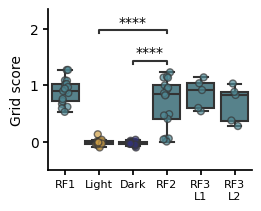

In [28]:
rowSize,colSize=2,2.5
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(mainSpec[0]) # add an axes to the figure
plotGridScoresLever(ax,dfMapStats, selection="gridCell_FIRST",statUnit="mouse",occupancyControlledStats=False,
               dfControlMapStats=None,printStats=True)

In [29]:
def plot_grid_cell_stats_lever(spec):
    """
    Function to plot stats for grid cells: 
    
    Arguments:
    spec: A spec with one col and one row on which you want to place the examples maps
    """
    
    ncols=2
    nrows=3

    statsSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=spec[0])
    
    selection="gridCell_FIRST" # grid cells selected on the first RF trial
    statUnit="mouse" 
    occupancyControl=False 

    ax = fig.add_subplot(statsSpec[0,0]) # add an axes to the figure
    plotGridScoresLever(ax,dfMapStats,selection=selection,statUnit="mouse",occupancyControlledStats=occupancyControl,dfControlMapStats=dfControlMapStats,printStats=True)

    ax = fig.add_subplot(statsSpec[0,1]) # add an axes to the figure
    plotMeanRateLever(ax,dfMapStats,selection=selection,statUnit="mouse",printStats=True)

    ax = fig.add_subplot(statsSpec[1,0]) # add an axes to the figure
    plotPeakRatesLever(ax,dfMapStats,selection=selection,statUnit="mouse",occupancyControlledStats=occupancyControl,dfControlMapStats=dfControlMapStats,printStats=True)


    ax = fig.add_subplot(statsSpec[1,1]) # add an axes to the figure
    plotInfoScoresLever(ax,dfMapStats,selection=selection,statUnit="mouse",occupancyControlledStats=occupancyControl,dfControlMapStats=dfControlMapStats,printStats=True)

    ax = fig.add_subplot(statsSpec[2,:]) 
    map_stabilityLever(ax,dfMapCor,cells,statUnit="mouse",selection="gridCell_FIRST",printStats=True)



Median of RF1-RF2: 0.813
Statistics map sim, Wilcoxon, Light-Dark vs Light1-Light2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, Light-Dark vs Dark1-Dark2
N=0 S=0.0 $P$ = 1.53e-05
Median of RF1-Light: 0.017
Statistics map sim, Wilcoxon, RF1-Light vs Light1-Light2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, RF1-Dark vs Dark1-Dark2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, Light1-Light2 vs Dark1-Dark2
N=0 S=17.0 $P$ = 0.0032
***Stats on lever starts here***
Statistics map sim, Wilcoxon, RF1-RF3_lever vs RF3_lever-RF3_lever2
N=5 S=7.0 $P$ = 1.0
***Stats on lever ends here***
Statistics map sim, Wilcoxon, Light-Dark vs RF1-Light
N=0 S=37.0 $P$ = 0.064
Statistics map sim, Wilcoxon, Light-Dark vs Light1-Light2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, Light-Dark vs Dark1-Dark2
N=0 S=0.0 $P$ = 1.53e-05
Median of RF1-Dark: 0.014
Statistics map sim, Wilcoxon, Light-Dark vs RF1-Dark
N=0 S=25.0 $P$ = 0.013
Median of RF3_lever-RF3_lever2: 0.721


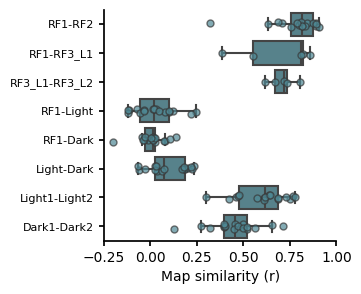

In [30]:
fig, ax =plt.subplots(figsize=(3,3))
map_stabilityLever(ax,dfMapCor,cells,statUnit="mouse",selection="gridCell_FIRST",printStats=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dark vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
Light vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
**************Grid score stats************
Statistics grid scores, Wilcoxon, Light vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Wilcoxon, Dark vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Mann-Whitney U test, Light vs RF3-lever
N1=17, N2=5, U=0.0, $P$ = 7.59e-05

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dark vs. RF2: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=1.000e+00


Light vs. RF2: Wilcoxon test (paired samples), P_val:3.815e-04 Stat=8.000e+00
**************Mean rate stats************
Statistics mean rate, Wilcoxon, Light vs RF2
N=17 S=8.0 $P$ = 3.81e-04
Statistics mean rate, Wilcoxon, Dark vs RF2
N=17 S=1.0 $P$ = 3.05e-05
Statistics mean rate, Wilcoxon, Dark vs Light
N=17 S=40.0 $P$ = 0.089
Median of Dark Vs Light difference in mean rate: -0.28 Hz
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Light vs. Dark: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=1.000e+00


/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Dark vs. RF2: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=1.000e+00
**************Peak rate stats************
Statistics peak rates, Wilcoxon, Light vs RF2
N=17 S=62.0 $P$ = 0.52
Statistics peak rates, Wilcoxon, Dark vs RF2
N=17 S=1.0 $P$ = 3.05e-05
Statistics peak rates, Wilcoxon, Dark vs Light
N=17 S=1.0 $P$ = 3.05e-05

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Light vs. Dark: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00


/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Dark vs. RF2: Wilcoxon test (paired samples), P_val:1.068e-04 Stat=4.000e+00
**************Info score stats************
Statistics info scores, Wilcoxon, Light vs RF2
N=17 S=45.0 $P$ = 0.15
Statistics info scores, Wilcoxon, Dark vs RF2
N=17 S=4.0 $P$ = 1.07e-04
Statistics info scores, Wilcoxon, Dark vs Light
N=17 S=0.0 $P$ = 1.53e-05

Median of RF1-RF2: 0.813
Statistics map sim, Wilcoxon, Light-Dark vs Light1-Light2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, Light-Dark vs Dark1-Dark2
N=0 S=0.0 $P$ = 1.53e-05
Median of RF1-Light: 0.017
Statistics map sim, Wilcoxon, RF1-Light vs Light1-Light2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, RF1-Dark vs Dark1-Dark2
N=0 S=0.0 $P$ = 1.53e-05
Statistics map sim, Wilcoxon, Light1-Light2 vs Dark1-Dark2
N=0 S=17.0 $P$ = 0.0032
***Stats on lever starts here***
Statistics map sim, Wilcoxon, RF1-RF3_lever vs RF3_lever-RF3_lever2
N=5 S=7.0 $P$ = 1.0
***Stats on lever ends here***
Statistics map sim, Wilcoxon, Light-Dark vs RF1-Lig

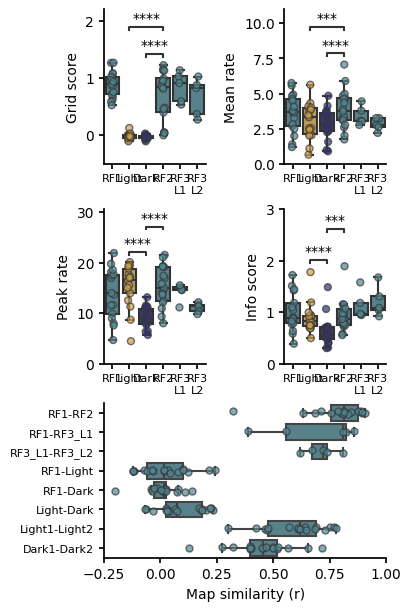

In [31]:
rowSize,colSize=2,2
ncols=2
nrows=3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
plot_grid_cell_stats_lever(mainSpec)

Figure width: 11.0
Figure height: 6.12
                         cluId               session   mouse  refractory  \
2826  jp1686-29042022-0109_189  jp1686-29042022-0109  jp1686    0.081283   
6213  jp3269-30112022-0110_329  jp3269-30112022-0110  jp3269    0.030641   
3228  jp3120-27052022-0110_160  jp3120-27052022-0110  jp3120    0.053101   
2813  jp1686-29042022-0109_119  jp1686-29042022-0109  jp1686    0.026066   

      refractoryClean  usable  meanRate  sumShortAuto  meanRateStable  \
2826             True    True  2.501244       20135.0            True   
6213             True    True  3.243708       50818.0            True   
3228             True    True  3.416877       25006.0            True   
2813             True    True  2.728347       25217.0            True   

      gridCell_AND  gridCell_OR  gridCell_FIRST  gridCell  \
2826          True         True            True      True   
6213          True         True            True      True   
3228          True         True

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dark vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
Light vs. RF2: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
**************Grid score stats************
Statistics grid scores, Wilcoxon, Light vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Wilcoxon, Dark vs RF2
N=17 S=0.0 $P$ = 1.53e-05
Statistics grid scores, Mann-Whitney U test, Light vs RF3-lever
N1=17, N2=5, U=0.0, $P$ = 7.59e-05

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Dark vs. RF2: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=1.000e+00
Light vs. RF2: Wilcoxon test (paired samples), P_val:3.815e-04 Stat=8.000e+00
**************Mean

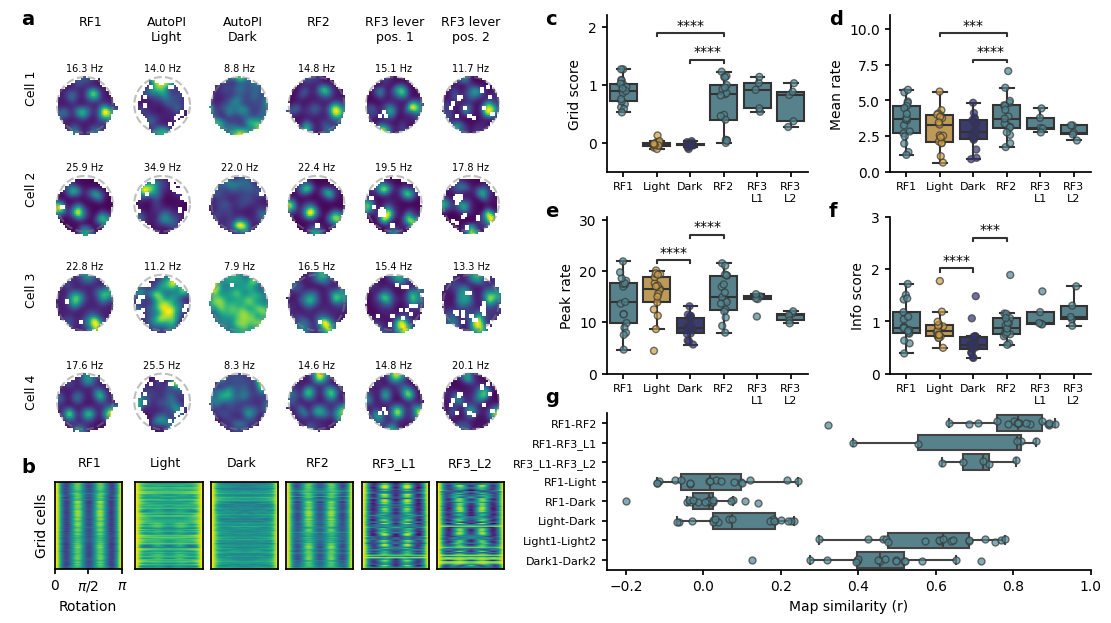

In [32]:
rowSize,colSize=1.7,2 #figurePanelDefaultSize()
ncols=5.5
nrows=3.6

print("Figure width: {}".format(ncols*colSize))
print("Figure height: {}".format(nrows*rowSize))


fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=3, nrows=2,
                           height_ratios = [0.01,1],
                           width_ratios = [0.01,1,1.2]) # to be passed to a drawing function, one row and one column, in this case covering the entire figure but does not have to be.


mapSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,1])
statSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,2])
letterSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[:,:])

maps_with_doughnut_rotation_two_lever(mapSpec)
plot_grid_cell_stats_lever(statSpec)

ax = fig.add_subplot(letterSpec[0])
ax.text(0.01, 0.98, "a",style="normal", fontsize=14, weight="bold")
ax.text(0.01, 0.235, "b",style="normal", fontsize=14, weight="bold")

ax.text(0.49, 0.98, "c",style="normal", fontsize=14, weight="bold")
ax.text(0.75, 0.98, "d",style="normal", fontsize=14, weight="bold")

ax.text(0.49, 0.66, "e",style="normal", fontsize=14, weight="bold")
ax.text(0.75, 0.66, "f",style="normal", fontsize=14, weight="bold")

ax.text(0.49, 0.35, "g",style="normal", fontsize=14, weight="bold")
ax.axis("off")

plt.savefig('../../Output/Figure2.pdf', bbox_inches='tight', dpi=300)